<a href="https://colab.research.google.com/github/rahiakela/small-language-models-fine-tuning/blob/main/domain-specific-small-language-models/06-generate-protein-structures/02_antibody_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Antibody Generation with AntibodyGPT

Antibody Generator (also referred as AntibodyGPT), which is a specialized protein generation model developed for creating therapeutic antibody sequences for use in immunology, vaccine development, and medical treatments.

Antibodies are proteins that protect us when an unwanted foreign substance(called antigen) enters our body. Produced by our immune system, antibodies bind to unwanted substances in order to eliminate them from our body.

The baseline model for the Antibody Generator is **ProGen2**, trained on a dataset of over 280 million protein sequences, follows a decoder-only architecture, is made of models of four different sizes:

1. small(151 million parameters),
2. medium (765 million parameters),
3. large (2.7 billion parameters) and
4. extra-large (6.4 billion parameters).

The Antibody Generator models have been done by using the Progen2 small, medium and large options as baseline and fine tuning them with 5000 experimentally resolved
crystal structures of antibodies and their antigens.

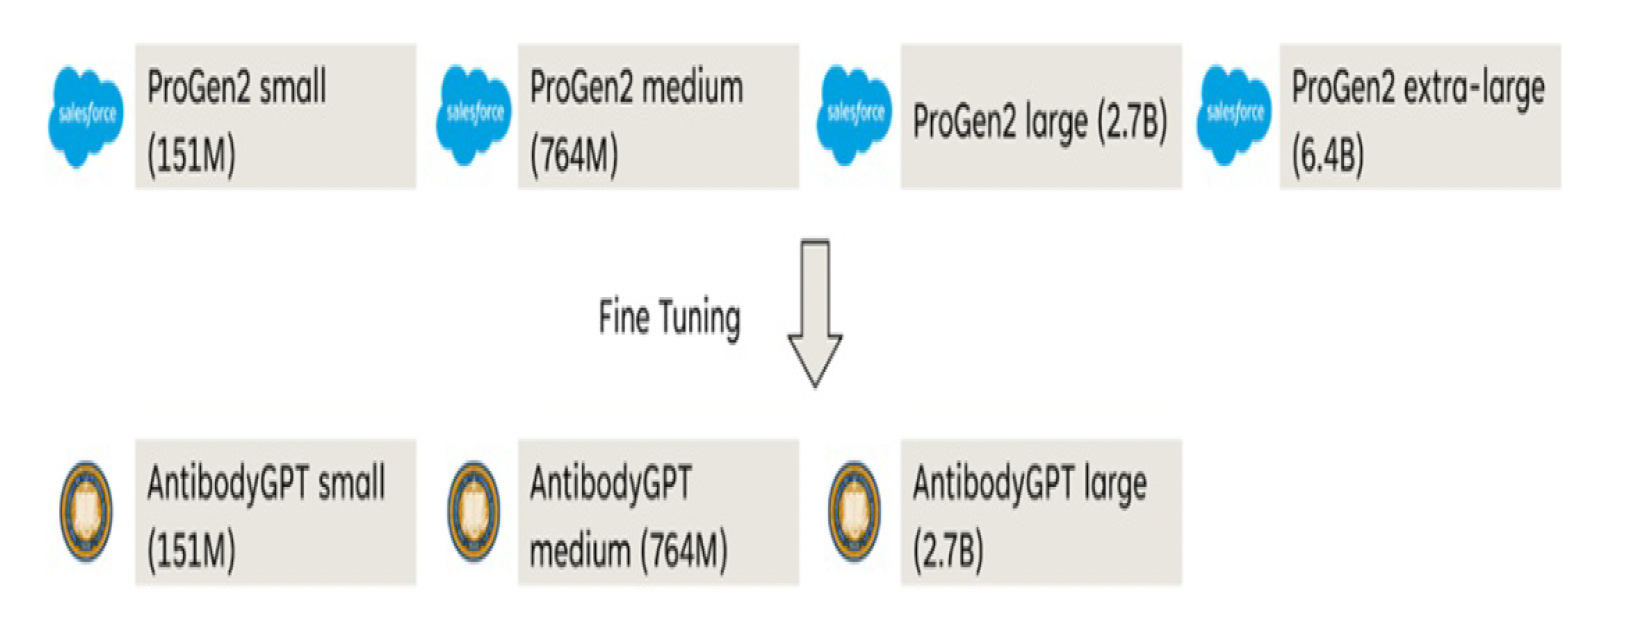

## Download Model

Let’s learn how to do inference with AntibodyGPT.

The code in this notebook is to generate antibody sequences using the [AntibodyGPT](https://huggingface.co/AntibodyGeneration/fine-tuned-progen2-small) model. It requires hardware acceleration.  

Downgrading the HF's Transformers library to ensure compatibility with the AntibodyGPT2's `ProGenForCausalLM` class, as it inherits from `PreTrainedModel`, which, starting from Transformers release 4.50, wouldn't inherit from `GenerationMixin` anymore, in so loosing the availability of the `generate` method.

In [ ]:
!pip install transformers==4.49.0

Clone the official repo.

In [ ]:
!git clone https://github.com/joethequant/docker_protein_generator.git
%cd ./docker_protein_generator/

## Load Model

Download one of the pretrained models and the associated tokenizer from the HF's Hub. Please note that the AutoClass to use is the custom ```ProGenForCausalLM``` available in the ```docker_protein_generator``` cloned repo.



In [ ]:
from models.progen.modeling_progen import ProGenForCausalLM
import torch
from tokenizers import Tokenizer

model_path = 'AntibodyGeneration/fine-tuned-progen2-small'

model = ProGenForCausalLM.from_pretrained(model_path)
tokenizer = Tokenizer.from_pretrained(model_path)

In [7]:
from pathlib import Path

models_path = Path("antibodygen")
model.save_pretrained(models_path)

The save model to disk is 588.6 MB (617 MB in memory after download).

## Do Innference

Define a target antigen sequence and the number of antibody sequences you want to generate for it and then start the generation process.

In [8]:
target_sequence = 'MQIPQAPWPVVWAVLQLGWRPGWFLDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTDKLAAFPEDRSQPGQDCRFRVTQLPNGRDFHMSVVRARRNDSGTYLCGAISLAPKAQIKESLRAELRVTERRAEVPTAHPSPSPRPAGQFQTLVVGVVGGLLGSLVLLVWVLAVICSRAARGTIGARRTGQPLKEDPSAVPVFSVDYGELDFQWREKTPEPPVPCVPEQTEYATIVFPSGMGTSSPARRGSADGPRSAQPLRPEDGHCSWPL'
number_of_sequences = 2

Tokenize the prompt sequence and then convert it to PyTorch tensor and move it to the GPU.

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenized_sequence = tokenizer.encode(target_sequence)
input_tensor = torch.tensor([tokenized_sequence.ids]).to(device)

Move the model to GPU.

In [10]:
model = model.to(device)

Start the sequence generation.

In [11]:
with torch.no_grad():
    output = model.generate(input_tensor, max_length=1024,
                            pad_token_id=tokenizer.encode('<|pad|>').ids[0],
	                          do_sample=True, top_p=0.9, temperature=0.8,
	                          num_return_sequences=number_of_sequences)


Decode the generated sequences and display them.

In [12]:
as_lists = lambda batch: [batch[i, ...].detach().cpu().numpy().tolist() for i in range(batch.shape[0])]
sequences = tokenizer.decode_batch(as_lists(output))
if len(sequences) > 0:
    sequences = [x.replace('2', '') for x in sequences]

In [13]:
sequences

['MQIPQAPWPVVWAVLQLGWRPGWFLDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTDKLAAFPEDRSQPGQDCRFRVTQLPNGRDFHMSVVRARRNDSGTYLCGAISLAPKAQIKESLRAELRVTERRAEVPTAHPSPSPRPAGQFQTLVVGVVGGLLGSLVLLVWVLAVICSRAARGTIGARRTGQPLKEDPSAVPVFSVDYGELDFQWREKTPEPPVPCVPEQTEYATIVFPSGMGTSSPARRGSADGPRSAQPLRPEDGHCSWPLARGHPKPTDPAAIYALKWTDIHKLGHLCRSPYGLYTSAPTAVDSNHLATCRFAGVGTGGPPPPRDPRPPSPPGGPGGGGSGGGGSGGGGSEVKLVESGGGLVKPGGSLRLSCAASGFTFSSYDMSWIRQAPGKGLEWVSYISSSGTTIYYADSVKGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCTRPTRGGPELAFDIWGQGTMVTVSSASTKGPSVFPLAPCSRSTSESTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTKTYTCNVDHKPSNTKVDKRVESGGGGSGGGGSGGGGSEIVLTQSPGTLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRLLIYDASNRATGIPARFTGSGSGTDFTLTISRLEPEDFAVYYCQQYGRSRWTFGQGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLRSPVTKSFNRGEC',
 'MQIPQAPWPVVWAVLQLGWRPGWFLDSPDRPWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTDKLAAFPEDRSQPGQDCRFRVTQLPNGRDFHMSVVRARRNDSGTYLCGAISLAPKAQIKESLRAELRVTERRAEVPTAHPSPSPRPAGQ